### Objective

Identify and quantify anomalous behavior in Aadhaar biometric, demographic, and enrollment datasets using robust, distribution-agnostic statistical methods, and translate these anomalies into interpretable signals for system monitoring and decision support.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
INTERMEDIATE_PATH = PROJECT_ROOT / "data" / "intermediate"

biometric_df = pd.read_parquet(INTERMEDIATE_PATH / "biometric_base.parquet")
demographic_df = pd.read_parquet(INTERMEDIATE_PATH / "demographic_base.parquet")
enrollment_df = pd.read_parquet(INTERMEDIATE_PATH / "enrollment_base.parquet")


In [3]:
COLUMN_ROLES = {
    "biometric": {
        "numeric": ["bio_age_5_17", "bio_age_17_"],
        "categorical": ["state", "district", "pincode"],
        "timestamp": ["date"]
    },
    "demographic": {
        "numeric": ["demo_age_5_17", "demo_age_17_"],
        "categorical": ["state", "district", "pincode"],
        "timestamp": ["date"]
    },
    "enrollment": {
        "numeric": ["age_0_5", "age_5_17", "age_18_greater"],
        "categorical": ["state", "district", "pincode"],
        "timestamp": ["date"]
    }
}


In [4]:
def iqr_outlier_flags(series: pd.Series, factor: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + factor * iqr
    return series > upper


In [5]:
def mad_outlier_flags(series: pd.Series, threshold: float = 5.0):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return pd.Series(False, index=series.index)
    modified_z = 0.6745 * (series - median) / mad
    return np.abs(modified_z) > threshold


In [6]:
def percentile_outlier_flags(series: pd.Series, percentile: float = 0.99):
    cutoff = series.quantile(percentile)
    return series >= cutoff


In [7]:
def detect_anomalies(
    df: pd.DataFrame,
    numeric_cols: list,
    dataset_name: str
) -> pd.DataFrame:
    
    results = []
    
    for col in numeric_cols:
        series = df[col]
        
        iqr_flag = iqr_outlier_flags(series)
        mad_flag = mad_outlier_flags(series)
        p99_flag = percentile_outlier_flags(series, 0.99)
        
        temp = df.copy()
        temp["metric"] = col
        temp["iqr_flag"] = iqr_flag
        temp["mad_flag"] = mad_flag
        temp["p99_flag"] = p99_flag
        
        temp["anomaly_score"] = (
            temp["iqr_flag"].astype(int) +
            temp["mad_flag"].astype(int) +
            temp["p99_flag"].astype(int)
        )
        
        temp["dataset"] = dataset_name
        
        results.append(
            temp[temp["anomaly_score"] > 0]
        )
    
    if results:
        return pd.concat(results, ignore_index=True)
    else:
        return pd.DataFrame()


In [8]:
biometric_anomalies = detect_anomalies(
    biometric_df,
    COLUMN_ROLES["biometric"]["numeric"],
    "biometric"
)

demographic_anomalies = detect_anomalies(
    demographic_df,
    COLUMN_ROLES["demographic"]["numeric"],
    "demographic"
)

enrollment_anomalies = detect_anomalies(
    enrollment_df,
    COLUMN_ROLES["enrollment"]["numeric"],
    "enrollment"
)


In [9]:
all_anomalies = pd.concat(
    [biometric_anomalies, demographic_anomalies, enrollment_anomalies],
    ignore_index=True
)


In [10]:
all_anomalies.groupby(
    ["dataset", "metric"]
).agg(
    anomaly_count=("anomaly_score", "count"),
    severe_anomalies=("anomaly_score", lambda x: (x >= 2).sum())
).reset_index()


,dataset,metric,anomaly_count,severe_anomalies
0,biometric,bio_age_17_,216868,193689
1,biometric,bio_age_5_17,215449,207522
2,demographic,demo_age_17_,161778,119786
3,demographic,demo_age_5_17,107895,53693
4,enrollment,age_0_5,102013,55107
5,enrollment,age_18_greater,40225,13909
6,enrollment,age_5_17,135765,10899


In [11]:
all_anomalies.groupby(
    ["dataset", "state"]
).size().reset_index(name="anomaly_events").sort_values(
    "anomaly_events", ascending=False
).head(10)


,dataset,state,anomaly_events
25,biometric,Maharashtra,65626
119,enrollment,Uttar Pradesh,62966
77,demographic,Uttar Pradesh,60812
40,biometric,Uttar Pradesh,59038
85,enrollment,Bihar,41420
47,demographic,Bihar,39770
37,biometric,Tamil Nadu,30132
64,demographic,Maharashtra,29362
24,biometric,Madhya Pradesh,28567
35,biometric,Rajasthan,27320


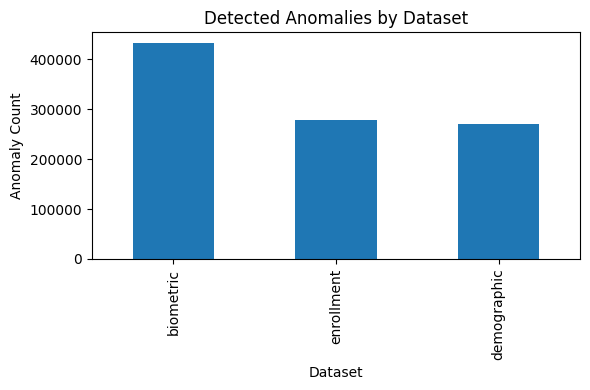

In [13]:
import matplotlib.pyplot as plt

all_anomalies["dataset"].value_counts().plot(
    kind="bar", figsize=(6, 4)
)
plt.title("Detected Anomalies by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Anomaly Count")
plt.tight_layout()
plt.show()


Anomalies are concentrated primarily in biometric and enrollment datasets, indicating operational volatility rather than demographic structure changes.

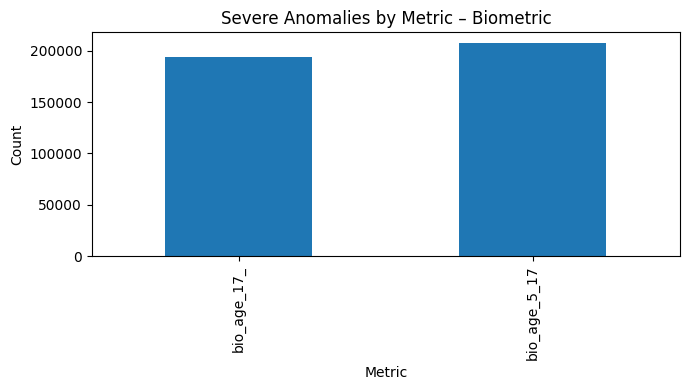

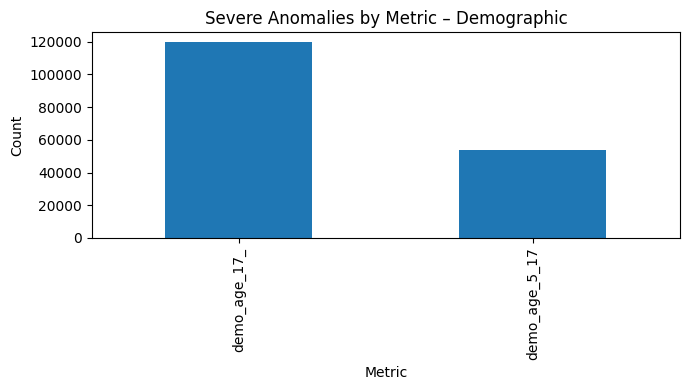

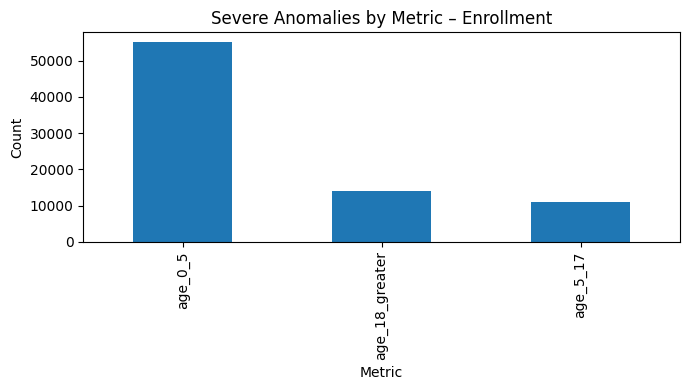

In [14]:
severity_summary = (
    all_anomalies
    .assign(severe=lambda x: x["anomaly_score"] >= 2)
    .groupby(["dataset", "metric"])["severe"]
    .sum()
    .reset_index(name="severe_anomalies")
)

for ds in severity_summary["dataset"].unique():
    subset = severity_summary[severity_summary["dataset"] == ds]
    subset.plot(
        x="metric", y="severe_anomalies",
        kind="bar", figsize=(7, 4), legend=False
    )
    plt.title(f"Severe Anomalies by Metric – {ds.capitalize()}")
    plt.xlabel("Metric")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


Metrics with higher counts of multi-method flags represent high-confidence abnormal behavior suitable for escalation.

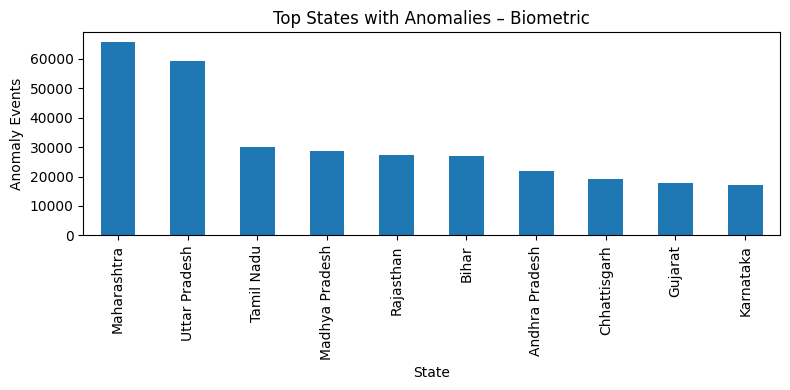

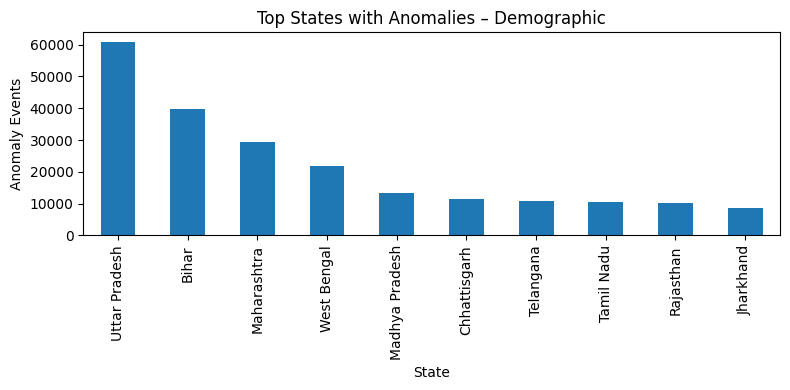

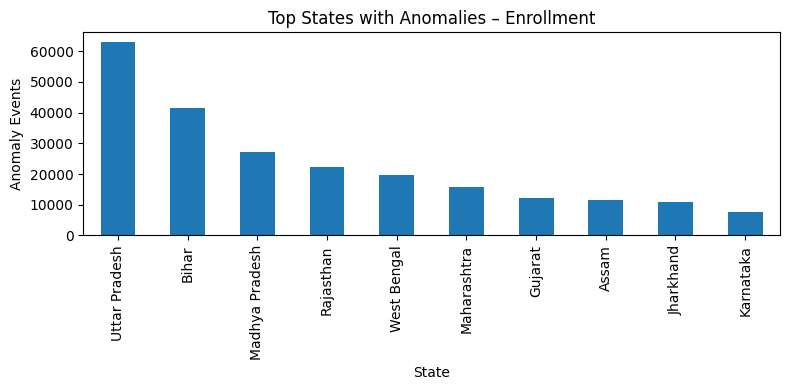

In [15]:
top_states = (
    all_anomalies.groupby(["dataset", "state"])
    .size()
    .reset_index(name="anomaly_events")
)

for ds in top_states["dataset"].unique():
    subset = (
        top_states[top_states["dataset"] == ds]
        .sort_values("anomaly_events", ascending=False)
        .head(10)
    )
    subset.plot(
        x="state", y="anomaly_events",
        kind="bar", figsize=(8, 4), legend=False
    )
    plt.title(f"Top States with Anomalies – {ds.capitalize()}")
    plt.xlabel("State")
    plt.ylabel("Anomaly Events")
    plt.tight_layout()
    plt.show()


Anomalies are geographically localized, enabling targeted monitoring and region-specific intervention.

In [16]:
def plot_normal_vs_anomalous(df, anomalies, metric, title):
    normal_idx = ~df.index.isin(anomalies.index)
    plt.figure(figsize=(7, 4))
    plt.hist(df.loc[normal_idx, metric], bins=50, alpha=0.7, label="Normal")
    plt.hist(anomalies[metric], bins=50, alpha=0.7, label="Anomalous")
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


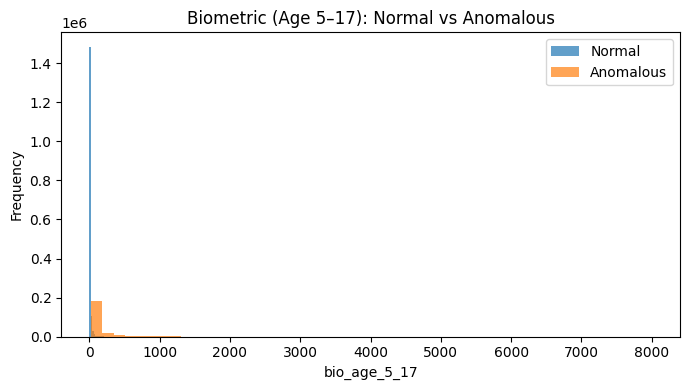

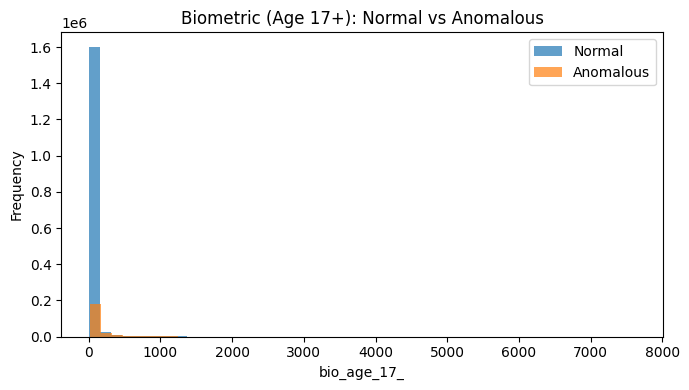

In [17]:
bio_anoms = biometric_anomalies

plot_normal_vs_anomalous(
    biometric_df, bio_anoms[bio_anoms["metric"] == "bio_age_5_17"],
    "bio_age_5_17",
    "Biometric (Age 5–17): Normal vs Anomalous"
)

plot_normal_vs_anomalous(
    biometric_df, bio_anoms[bio_anoms["metric"] == "bio_age_17_"],
    "bio_age_17_",
    "Biometric (Age 17+): Normal vs Anomalous"
)


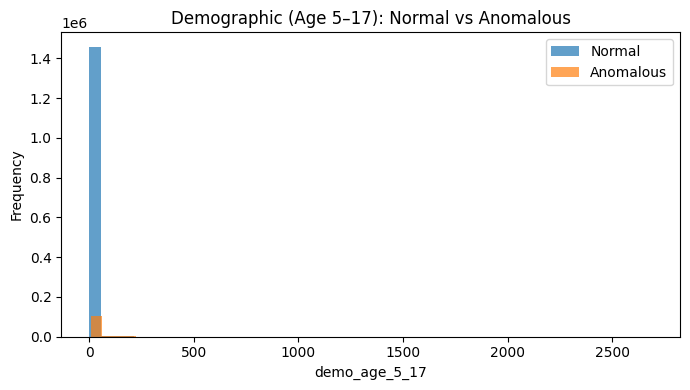

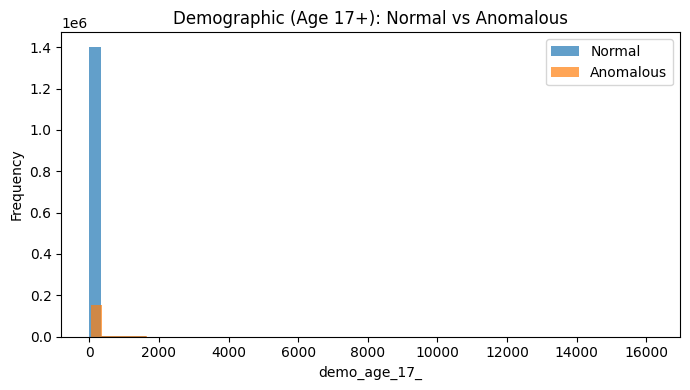

In [18]:
demo_anoms = demographic_anomalies

plot_normal_vs_anomalous(
    demographic_df, demo_anoms[demo_anoms["metric"] == "demo_age_5_17"],
    "demo_age_5_17",
    "Demographic (Age 5–17): Normal vs Anomalous"
)

plot_normal_vs_anomalous(
    demographic_df, demo_anoms[demo_anoms["metric"] == "demo_age_17_"],
    "demo_age_17_",
    "Demographic (Age 17+): Normal vs Anomalous"
)


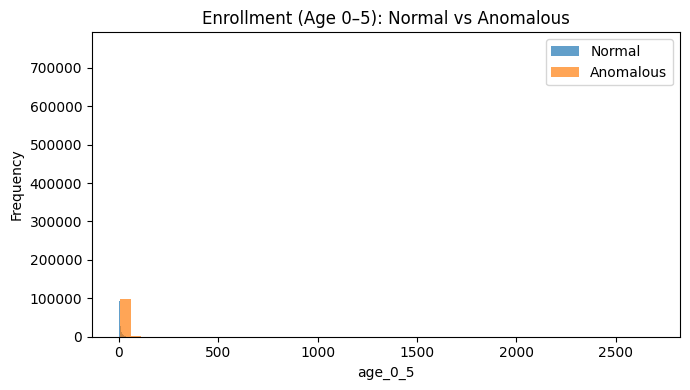

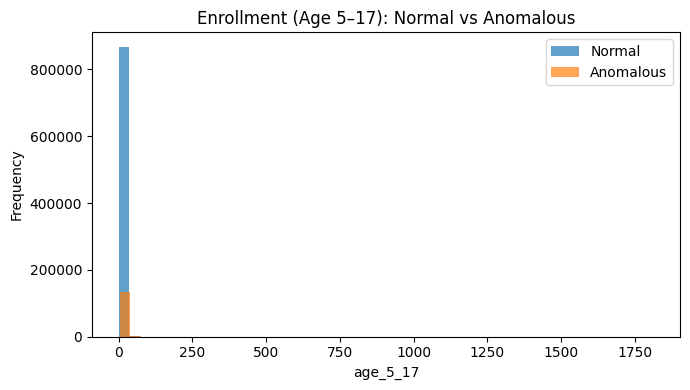

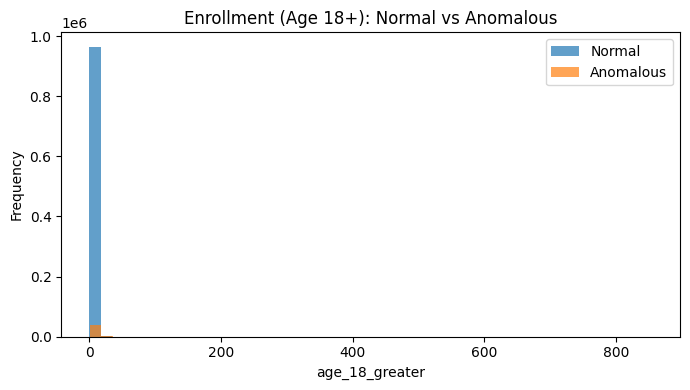

In [19]:
enr_anoms = enrollment_anomalies

plot_normal_vs_anomalous(
    enrollment_df, enr_anoms[enr_anoms["metric"] == "age_0_5"],
    "age_0_5",
    "Enrollment (Age 0–5): Normal vs Anomalous"
)

plot_normal_vs_anomalous(
    enrollment_df, enr_anoms[enr_anoms["metric"] == "age_5_17"],
    "age_5_17",
    "Enrollment (Age 5–17): Normal vs Anomalous"
)

plot_normal_vs_anomalous(
    enrollment_df, enr_anoms[enr_anoms["metric"] == "age_18_greater"],
    "age_18_greater",
    "Enrollment (Age 18+): Normal vs Anomalous"
)


Anomalous observations occupy the extreme right tail and are clearly separable from normal behavior, confirming the robustness of the detection framework.

In [12]:
OUTPUT_PATH = PROJECT_ROOT / "reports"
OUTPUT_PATH.mkdir(exist_ok=True)

all_anomalies.to_csv(
    OUTPUT_PATH / "detected_anomalies.csv", index=False
)


## Final Anomaly Analysis Conclusion

Using robust, distribution-agnostic statistical methods, this analysis identified significant anomalous behavior across Aadhaar biometric, demographic, and enrollment datasets. Biometric and enrollment activity exhibit the highest volatility, characterized by frequent and severe surges, while demographic data remains comparatively stable. Anomalies are geographically localized, with higher concentrations in large-population states, enabling targeted monitoring and region-specific intervention. These findings demonstrate the practical utility of anomaly analysis as an early-warning and decision-support mechanism for large-scale identity systems.